In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans 

## Exploration of features that could be included (with small dataset)

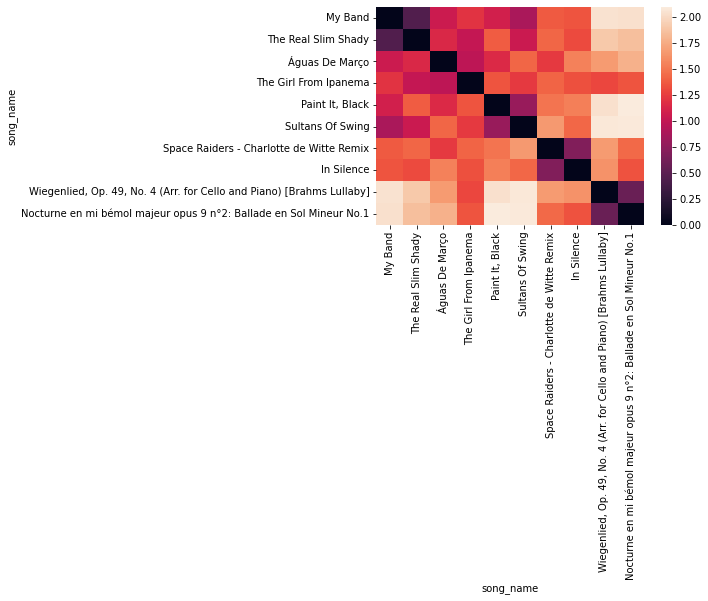

In [2]:
# import data
audio_features = pd.read_csv('data/df_audio_features_10.csv')

# choose columns to include in the model
relevant_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo']
features_only = audio_features[relevant_cols]

# initialize transformer to scale data to [0, 1]
min_max_scaler = MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(features_only)
features_only_scaled = min_max_scaler.transform(features_only)

features_only_scaled = pd.DataFrame(features_only_scaled,
                                    index= audio_features.song_name,
                                    columns= features_only.columns)

# compute pairwise distances between songs
euclidian_distances = pd.DataFrame(pairwise_distances(features_only_scaled), index= audio_features.song_name, columns= audio_features.song_name)

# visualize pairwise distances in heatmap
sns.heatmap(euclidian_distances);

## Choosing variables to include and importing data

In [3]:
# import data
features_big = pd.read_csv('data/df_audio_features_1000.csv')

In [4]:
features_big.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature', 'id',
       'html'],
      dtype='object')

In [5]:
# choose columns to include in the model (removed = key, mode, type, duration_ms, liveness, loudness)
cols = ['danceability', 'energy', 'speechiness', 'acousticness', 
        'instrumentalness', 'valence', 'tempo']

features_only = features_big[cols]

## Exploration of different scaling methods (big dataset)

### Range scaling

In [6]:
def range_scaler(col, min_value, max_value): 
    min_col = min_value
    max_col = max_value
    norm_val = []
    for val in col:
        norm_val.append((val - min_col) / (max_col - min_col))
    return norm_val

var_ranges = {'danceability': (0,1), 'energy': (0,1), 'key': (-1,11), 'loudness': (-60,0),
       'speechiness': (0,1), 'acousticness': (0,1), 'instrumentalness': (0,1), 'liveness': (0,1),
       'valence': (0,1)}

def range_scale_df(df):
    
    cols = df.columns
    scaled_cols = {}

    for col in cols:
        if col in var_ranges.keys():
            scaled_cols[col] = range_scaler(df[col], var_ranges[col][0], var_ranges[col][1])
        else:
            min_max_scaler = MinMaxScaler(feature_range= (0, 1))
            min_max_scaler.fit(df[[col]])
            scaled_cols[col] = list(min_max_scaler.transform(df[[col]]))
    
    features_only_range_scaled = pd.DataFrame(scaled_cols)
    return features_only_range_scaled

In [7]:
min_max_scaler = MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(features_only[['tempo']])
min_max_scaler.transform(features_only[['tempo']]).shape

(1440, 1)

In [18]:
range_scaled = range_scale_df(features_only)
range_scaled.set_index(features_big.name, inplace= True)
range_scaled['tempo'] = range_scaled['tempo'].astype('float64')

### Min max scaling

In [12]:
# initialize transformer to scale data to [0, 1]
min_max_scaler = MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(features_only)
features_only_min_max_scaled = min_max_scaler.transform(features_only)

min_max_scaled = pd.DataFrame(features_only_min_max_scaled,
                                index= features_big.name,
                                columns= features_only.columns)

### Standard scaling

In [13]:
# initialize transformer to remove the mean and scale by variance 
standard_scaler = StandardScaler()
standard_scaler.fit(features_only)
features_only_standard_scaled = standard_scaler.transform(features_only)

standard_scaled = pd.DataFrame(features_only_standard_scaled,
                                index= features_big.name,
                                columns= features_only.columns)

### Robust scaling

In [14]:
# initialize transformer to remove the median and scale by quantile range (more robust to outliers than standard scaler)
robust_scaler = RobustScaler()
robust_scaler.fit(features_only)
features_only_robust_scaled = robust_scaler.transform(features_only)

robust_scaled = pd.DataFrame(features_only_robust_scaled,
                                index= features_big.name,
                                columns= features_only.columns)

### Quantile Transforming

In [15]:
# initialize transformer to transform data to uniform distribution
quantile_transformer = QuantileTransformer()
quantile_transformer.fit(features_only)
features_only_quantile_transformed = quantile_transformer.transform(features_only)

quantile_transformed = pd.DataFrame(features_only_quantile_transformed,
                                index= features_big.name,
                                columns= features_only.columns)

### Visualize different scaling/transformation methods

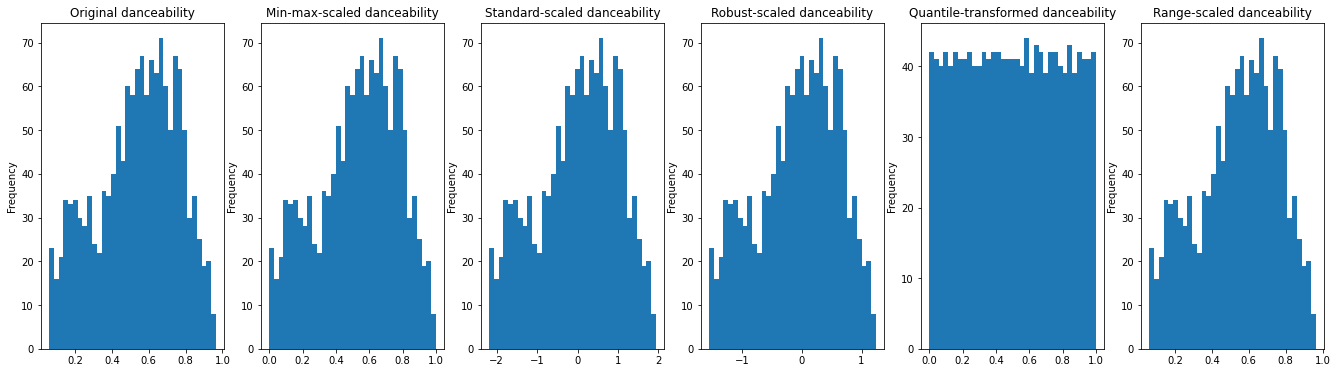

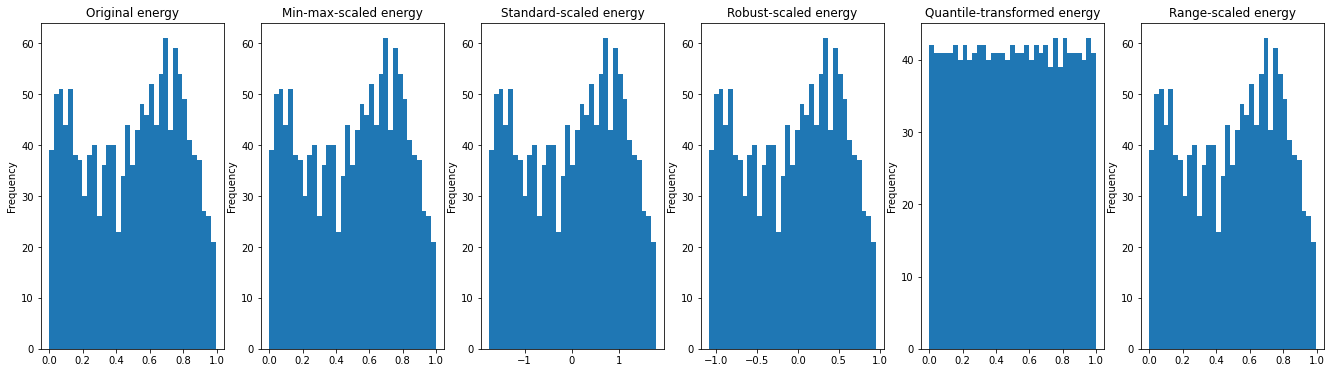

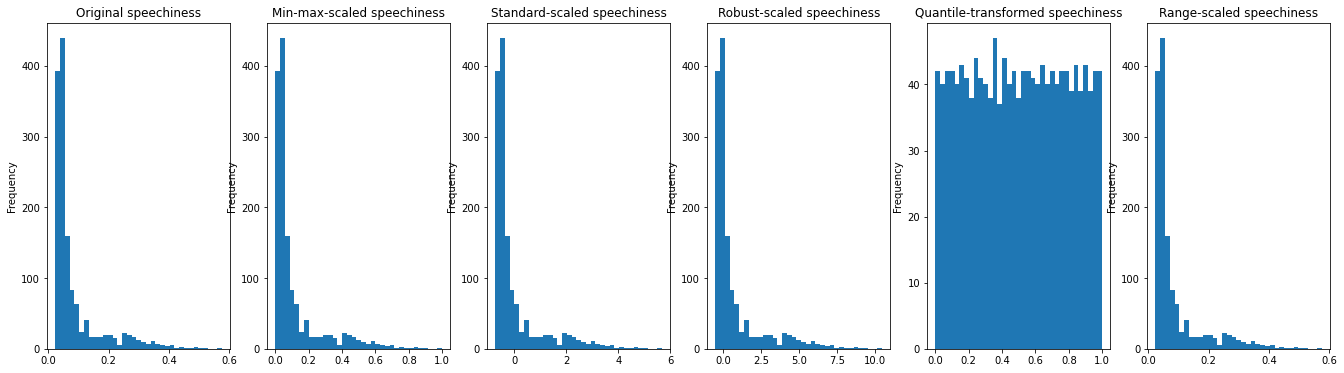

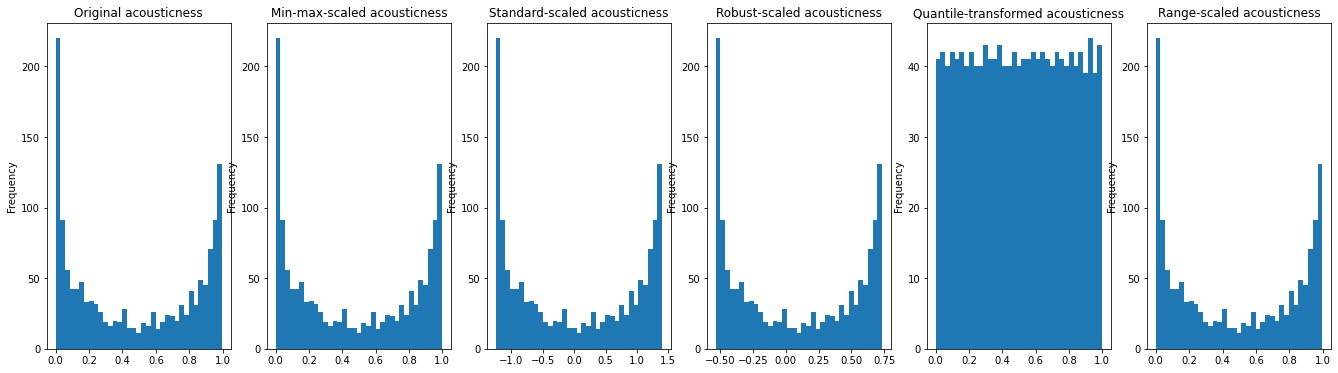

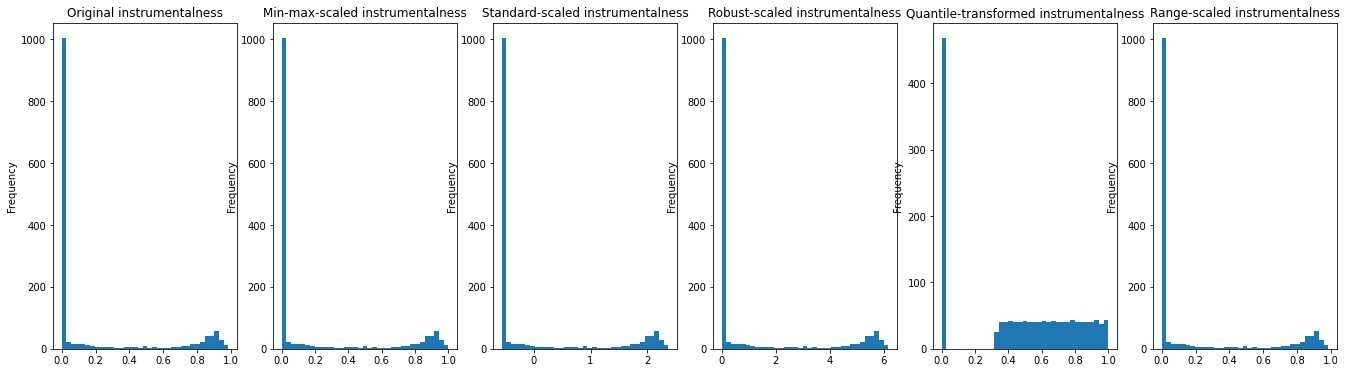

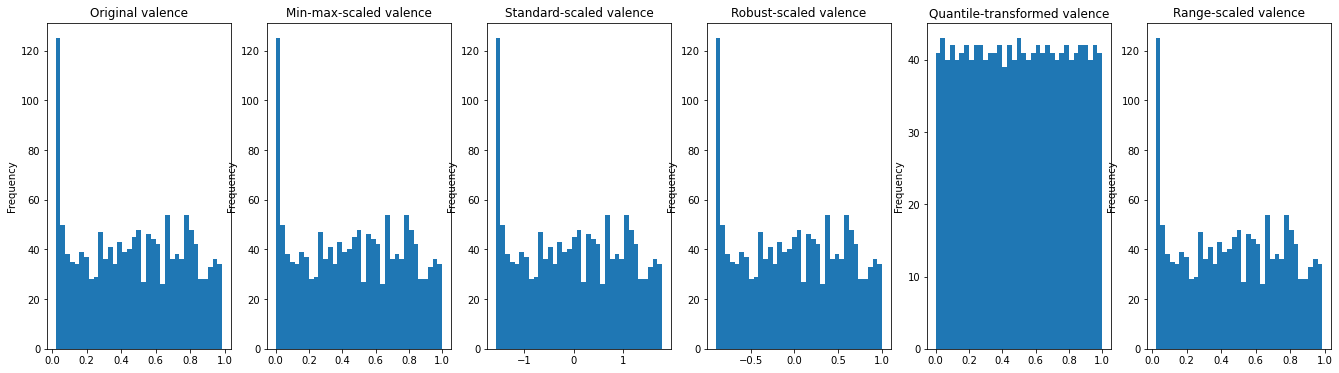

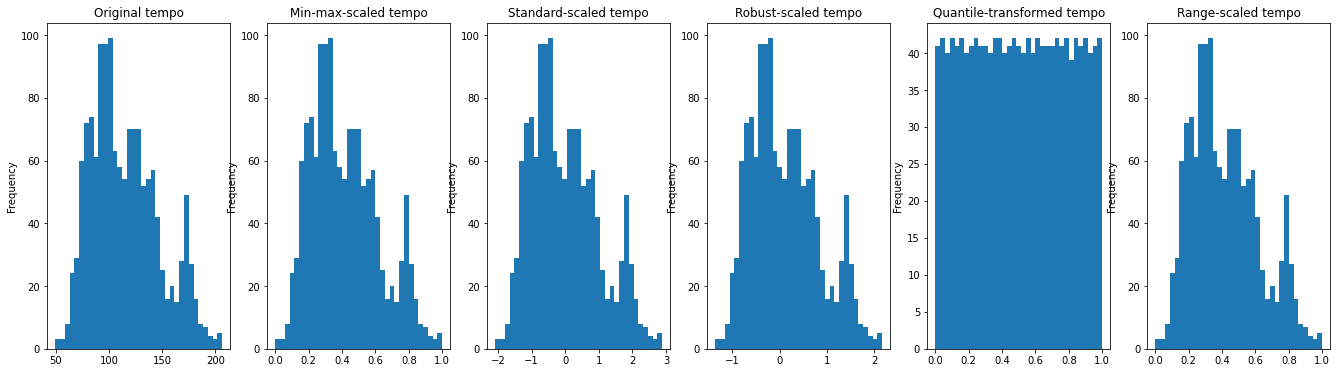

In [19]:
# loop through each relevant column to compare distributions

for var in cols:
    plt.figure(figsize=(23, 6))
    
    # plot original data
    plt.subplot(1, 6, 1)
    features_big[var].plot.hist(bins=35)
    plt.title(f"Original {var}")
    
    # plot min-max scaled data
    plt.subplot(1, 6, 2)
    min_max_scaled[var].plot.hist(bins=35)
    plt.title(f"Min-max-scaled {var}")

    # plot standard scaled data
    plt.subplot(1, 6, 3)
    standard_scaled[var].plot.hist(bins=35)
    plt.title(f"Standard-scaled {var}")

    # plot robust scaled data
    plt.subplot(1, 6, 4)
    robust_scaled[var].plot.hist(bins=35)
    plt.title(f"Robust-scaled {var}")

    # plot quantile transformed data
    plt.subplot(1, 6, 5)
    quantile_transformed[var].plot.hist(bins=35)
    plt.title(f"Quantile-transformed {var}")

     # plot range-scaled data
    plt.subplot(1, 6, 6)
    range_scaled[var].plot.hist(bins=35)
    plt.title(f"Range-scaled {var}")
    
    # show all plots
    plt.show()

### Decision on scaling method

For now, min-max-scaling is used to get an equal range of 0-1 for all variables.

## Find best k

In [11]:
def find_best_k(data, min_n_clusters, max_n_clusters):
    inertia_values = []
    silhouette_scores = []
    n_clusters = range(min_n_clusters, max_n_clusters + 1)

    for n in n_clusters:
        kmeans = KMeans(n_clusters= n)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    plt.subplots(figsize = (25,10))

    plt.subplot(1,2,1)
    plt.plot(n_clusters, inertia_values, 'bx-')
    plt.xticks(n_clusters)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Elbow Method For Optimal k')

    plt.subplot(1,2,2)
    plt.plot(n_clusters, silhouette_scores, 'bx-')
    plt.xticks(n_clusters)
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('Silhouette Scores For Optimal k')

    plt.show()

Min-max scaled:


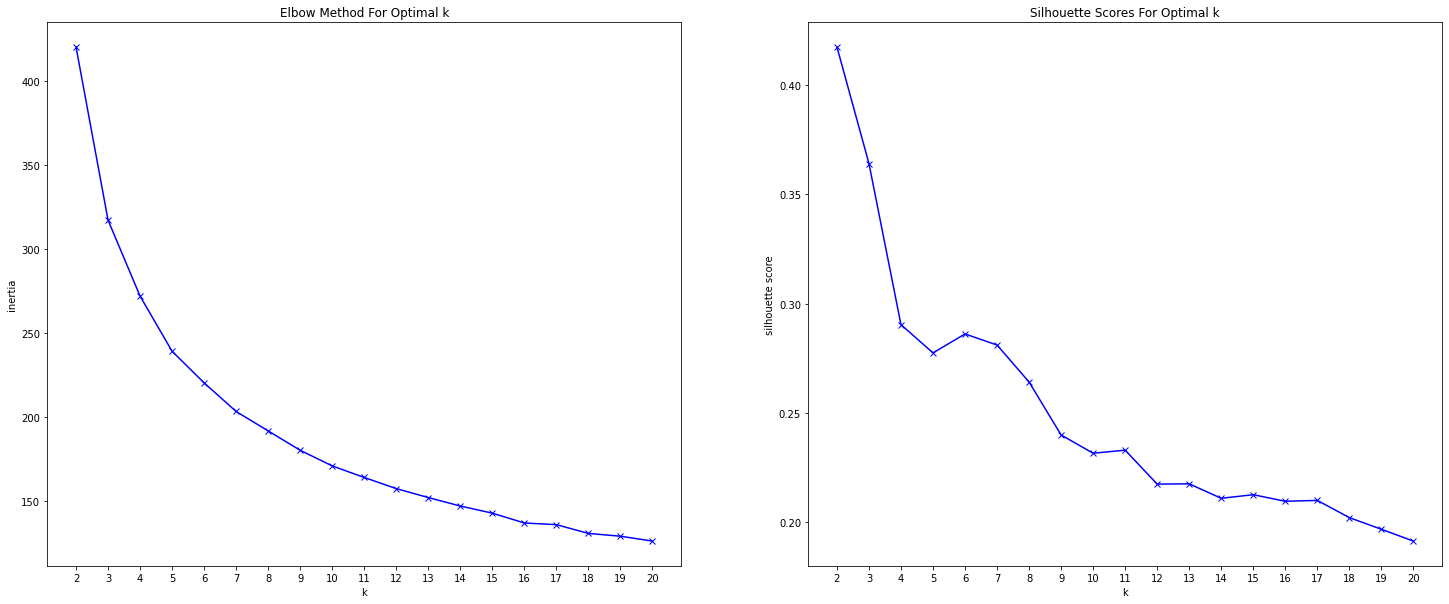

Standard scaled:


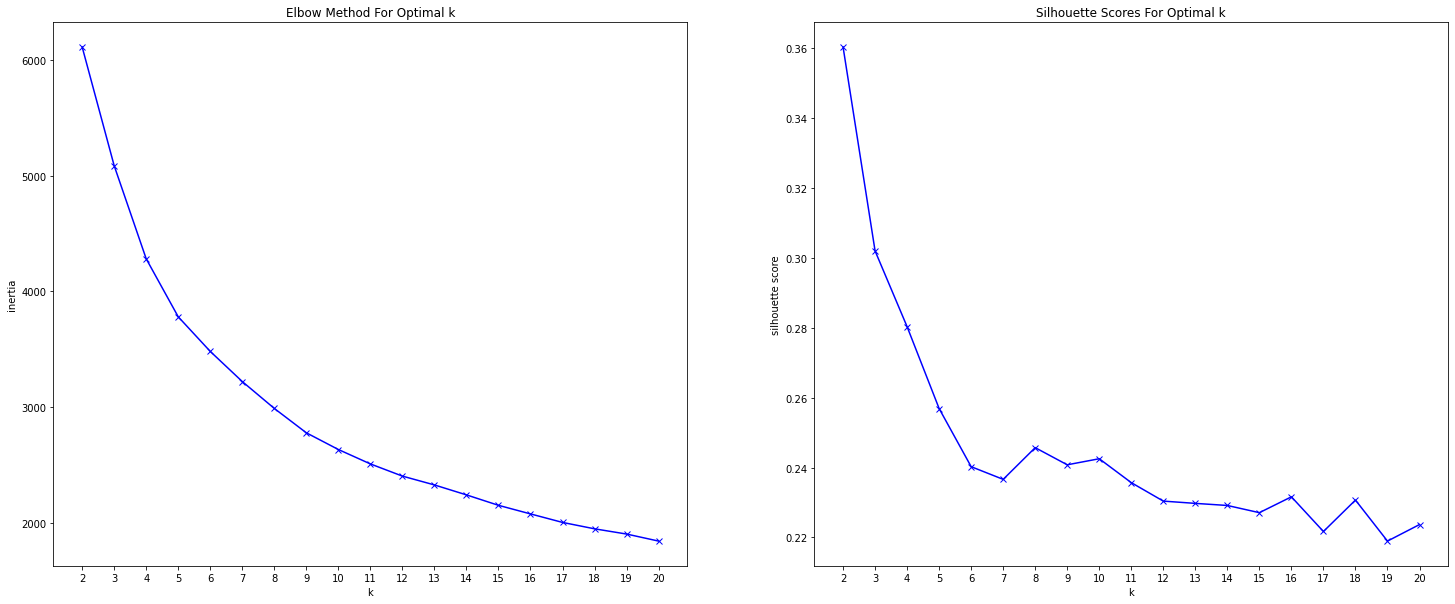

Robust scaled:


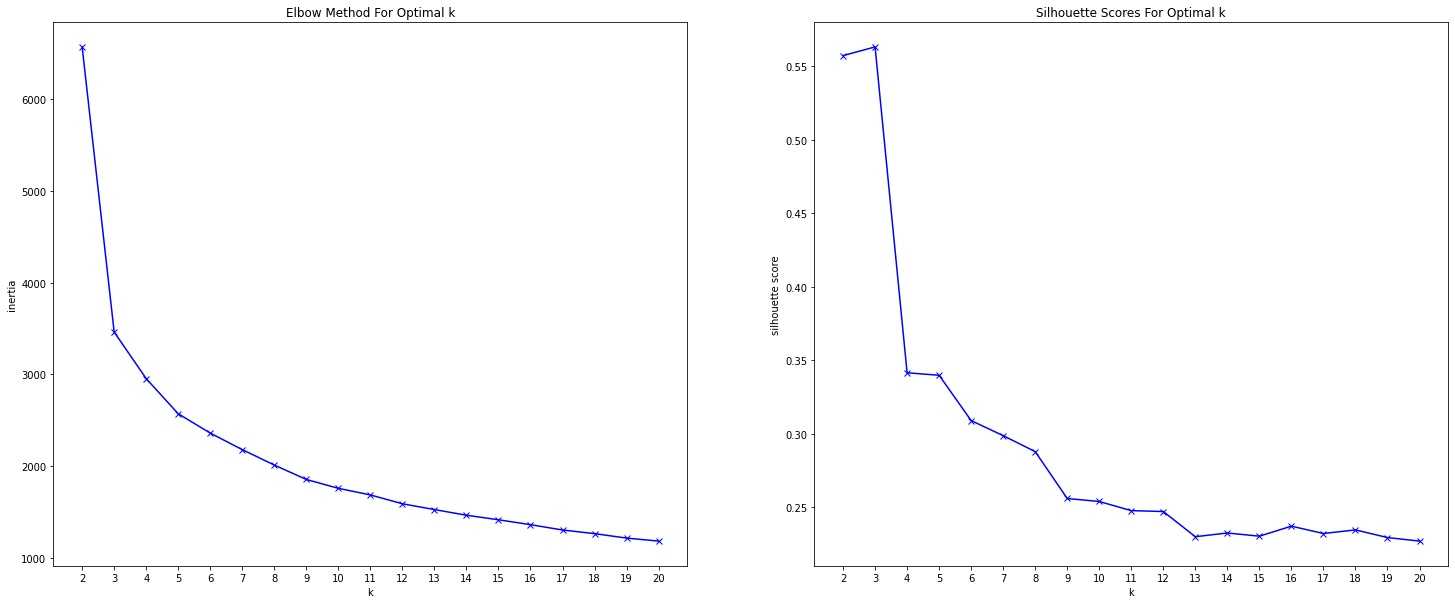

Quantile transformed:


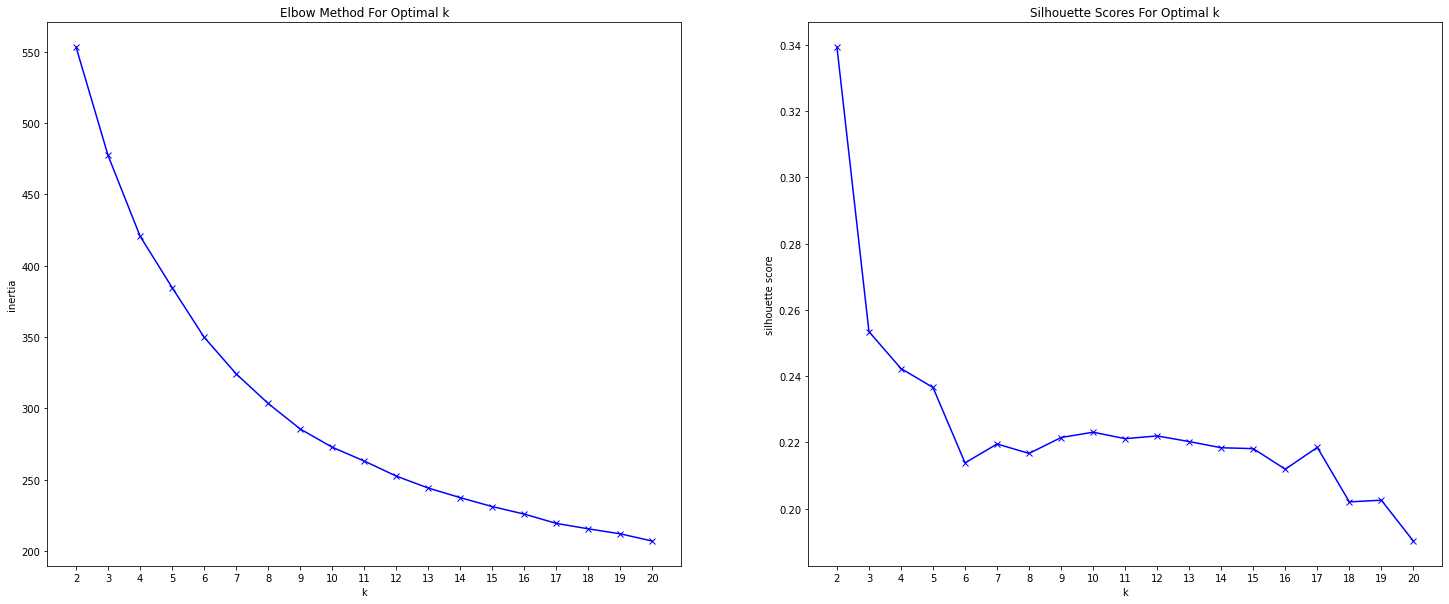

In [17]:
print('Min-max scaled:')
find_best_k(min_max_scaled, 2, 20)

print('Standard scaled:')
find_best_k(standard_scaled, 2, 20)

print('Robust scaled:')
find_best_k(robust_scaled, 2, 20)

print('Quantile transformed:')
find_best_k(quantile_transformed, 2, 20)

### Decision on k-value

* elbow plot is ambiguous - could be a value between 5-8 roughly
* silhouette plot shows sharper decline after k = 7
* based on these two sources a final k of 6 is chosen 

## Conduct clustering and explore results

### Create clusters

In [13]:
# initialize the clusters
kmeans = KMeans(n_clusters= 7)

# fit the clusters to the data
kmeans.fit(min_max_scaled) 

# obtain the cluster output
clusters = kmeans.predict(min_max_scaled)

# add the cluster output to the dataframe
features_big['cluster'] = clusters

# get centroids
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids)

### Explore clusters to find labels

In [14]:
(
    features_big
        [['danceability', 'energy', 'loudness',
        'speechiness', 'acousticness', 'instrumentalness', 
        'valence', 'tempo', 'cluster']]
        .groupby(by= 'cluster')
        .mean()
)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
cluster,,,,,,,,
0,0.756833,0.695987,-6.168833,0.291053,0.145337,0.007693,0.612773,112.624687
1,0.277111,0.156686,-20.912525,0.043376,0.899849,0.833653,0.143720,101.694290
2,0.363870,0.177006,-16.276382,0.044351,0.895925,0.045639,0.216409,104.303231
3,0.720615,0.693584,-6.855022,0.070649,0.150676,0.008863,0.773211,117.240252
4,0.518964,0.717035,-6.299991,0.083297,0.102353,0.018357,0.330317,130.209063
5,0.589704,0.464026,-10.313251,0.063816,0.679678,0.040601,0.641524,117.194154
6,0.565676,0.795324,-7.411135,0.081043,0.075831,0.759270,0.560314,154.132459


In [15]:
features_big.groupby(by = 'cluster').agg(count = ('name', 'count'))

,count
cluster,
0,150
1,259
2,186
3,317
4,224
5,267
6,37


In [16]:
# get titles of sample songs in clusters

features_big.loc[features_big['cluster'] == 1, 'name'].sample(10)


1396    Symphony No. 3: I. Molto moderato - with simpl...
1102                                      Lights On Water
1136                                                 4:14
1403                                Harmonielehre: Part I
775                                     A Day In The Life
811                Gary's Theme - 2003 Remastered Version
736                            Carmen Suite No.1: Prélude
786                              Someone To Watch Over Me
1387    Beethoven: Symphony No. 3 in E-Flat Major, Op....
1427    Symphony No. 6 in A Major, WAB 106 (ed. L. Now...
Name: name, dtype: object

### Cluster Labels
- 0 = ?
- 1 = ?
- 2 = ?
- 3 = ?
- 4 = ?
- 5 = ?
- 6 = ?